In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/DEM_Aware_Downscaling/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from utils.helpers_functions import read_dataset, z_score_normalize, denormalize_mae, compute_slope, compute_aspect
from utils.models_functions import psnr, ssim, load_model
from utils.display_functions import plot_degrees_mae, plot_to_compare
from utils.evaluation_functions import evaluate_per_pixel, measure_inference_time

In [3]:
dem_path='/content/drive/My Drive/DEM_Aware_Downscaling/dem_data/'
dates_path='/content/drive/My Drive/MSc_Thesis/input_data/index/'
lr_data_path='/content/drive/My Drive/MSc_Thesis/input_data/deg/0_5x0_5/'
hr_data_path='/content/drive/My Drive/MSc_Thesis/input_data/deg/0_25x0_25/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (320, 580)

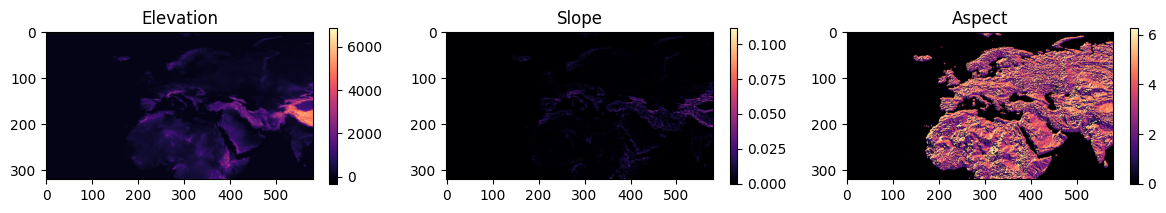

In [4]:
import matplotlib.pyplot as plt

dem_data_0_25 = np.load(dem_path+"dem_0_25.npy")
slope = compute_slope(dem_data_0_25, 0.25)
aspect = compute_aspect(dem_data_0_25)

plt.figure(figsize=(12, 2))

# Elevation
plt.subplot(1, 3, 1)
plt.title(f"Elevation")
plt.imshow(dem_data_0_25, cmap='magma')
plt.colorbar()

# Slope
plt.subplot(1, 3, 2)
plt.title(f"Slope")
plt.imshow(slope, cmap='magma')
plt.colorbar()

# Aspect
plt.subplot(1, 3, 3)
plt.title(f"Aspect")
plt.imshow(aspect, cmap='magma')
plt.colorbar()

plt.tight_layout()  # Ensures the subplots don't overlap
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, LeakyReLU, Lambda

# Load DEMs
dem_data_0_5 = np.load(dem_path + "dem_0_5.npy")
dem_data_0_25 = np.load(dem_path + "dem_0_25.npy")

# Compute aspect & slope
aspect_0_5 = compute_aspect(dem_data_0_5)
aspect_0_25 = compute_aspect(dem_data_0_25)
slope_0_5 = compute_slope(dem_data_0_5, 0.5)
slope_0_25 = compute_slope(dem_data_0_25, 0.25)

# Normalize static features
dem_data_0_5 = z_score_normalize(dem_data_0_5, np.mean(dem_data_0_5), np.std(dem_data_0_5))
aspect_0_5 = z_score_normalize(aspect_0_5, np.mean(aspect_0_5), np.std(aspect_0_5))
slope_0_5 = z_score_normalize(slope_0_5, np.mean(slope_0_5), np.std(slope_0_5))

dem_data_0_25 = z_score_normalize(dem_data_0_25, np.mean(dem_data_0_25), np.std(dem_data_0_25))
aspect_0_25 = z_score_normalize(aspect_0_25, np.mean(aspect_0_25), np.std(aspect_0_25))
slope_0_25 = z_score_normalize(slope_0_25, np.mean(slope_0_25), np.std(slope_0_25))

# ---- Convert to Tensors and Expand ----
def to_tensor(x): return tf.expand_dims(tf.constant(x, dtype=tf.float32), axis=-1)

dem_tensor_0_5 = to_tensor(dem_data_0_5)
aspect_tensor_0_5 = to_tensor(aspect_0_5)
slope_tensor_0_5 = to_tensor(slope_0_5)

dem_tensor_0_25 = to_tensor(dem_data_0_25)
aspect_tensor_0_25 = to_tensor(aspect_0_25)
slope_tensor_0_25 = to_tensor(slope_0_25)

def expand_static_data_dem_0_5(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(dem_tensor_0_5, 0), [batch_size, 1, 1, 1])

def expand_static_data_dem_0_25(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(dem_tensor_0_25, 0), [batch_size, 1, 1, 1])

def expand_static_aspect_0_5(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(aspect_tensor_0_5, 0), [batch_size, 1, 1, 1])

def expand_static_aspect_0_25(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(aspect_tensor_0_25, 0), [batch_size, 1, 1, 1])

def expand_static_slope_0_5(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(slope_tensor_0_5, 0), [batch_size, 1, 1, 1])

def expand_static_slope_0_25(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(slope_tensor_0_25, 0), [batch_size, 1, 1, 1])

# ---- Residual Block ----
def residual_block(x, filters=32, kernel_size=3, scaling=0.1):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = LeakyReLU(alpha=0.2)(res)
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = Lambda(lambda t: t * scaling)(res)
    return Add()([x, res])

In [6]:
_, _, testX, _, _, testY, _, _, testDates = read_dataset(dates_path, lr_data_path, hr_data_path, 'all', 2000, 2020, global_mean, global_Std)

# **No Elevation Aware**

In [ ]:
with open('models/history_0_5to0_25_deg_dem_0.pkl', 'rb') as f:
  nodem_history = pickle.load(f)

In [ ]:
nodem_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_0.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [ ]:
avg_ms = measure_inference_time(nodem_model, testX)
print(f"Average inference time per sample: {avg_ms:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
Average inference time per sample: 4.22 ms


In [ ]:
nodem_mse, nodem_mae, nodem_psnr, nodem_ssim = evaluate_per_pixel(nodem_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step


In [ ]:
degrees_mae_nodem = denormalize_mae(nodem_mae, global_Std)

# **Early Fusion**

In [ ]:
with open('models/history_0_5to0_25_deg_dem_1_new.pkl', 'rb') as f:
  early_history = pickle.load(f)

In [ ]:
early_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_1_new.keras', custom_objects={
    'psnr': psnr,
    'ssim': ssim,
    'residual_block': residual_block,
    'expand_static_data_dem_0_5': expand_static_data_dem_0_5
}, safe_mode=False)

In [ ]:
avg_ms = measure_inference_time(early_model, testX)
print(f"Average inference time per sample: {avg_ms:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Average inference time per sample: 3.04 ms


In [ ]:
early_mse, early_mae, early_psnr, early_ssim = evaluate_per_pixel(early_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


In [ ]:
degrees_mae_early = denormalize_mae(early_mae, global_Std)

# **Late Fusion**

In [ ]:
with open('models/history_0_5to0_25_deg_dem_2_new.pkl', 'rb') as f:
  late_history = pickle.load(f)

In [ ]:
late_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_2_new.keras', custom_objects={
    'psnr': psnr,
    'ssim': ssim,
    'residual_block': residual_block,
    'expand_static_data_dem_0_25': expand_static_data_dem_0_25
}, safe_mode=False)

In [ ]:
avg_ms = measure_inference_time(late_model, testX)
print(f"Average inference time per sample: {avg_ms:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Average inference time per sample: 3.37 ms


In [ ]:
late_mse, late_mae, late_psnr, late_ssim = evaluate_per_pixel(late_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step


In [ ]:
degrees_mae_late = denormalize_mae(late_mae, global_Std)

# **Combination**

In [ ]:
with open('models/history_0_5to0_25_deg_dem_3_new.pkl', 'rb') as f:
  comb_history = pickle.load(f)

In [ ]:
comb_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_3_new.keras', custom_objects={
    'psnr': psnr,
    'ssim': ssim,
    'residual_block': residual_block,
    'expand_static_data_dem_0_5': expand_static_data_dem_0_5,
    'expand_static_data_dem_0_25': expand_static_data_dem_0_25
}, safe_mode=False)

In [ ]:
avg_ms = measure_inference_time(comb_model, testX)
print(f"Average inference time per sample: {avg_ms:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Average inference time per sample: 3.35 ms


In [ ]:
comb_mse, comb_mae, comb_psnr, comb_ssim = evaluate_per_pixel(comb_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step


In [ ]:
degrees_mae_comb = denormalize_mae(comb_mae, global_Std)

## **History Plots**

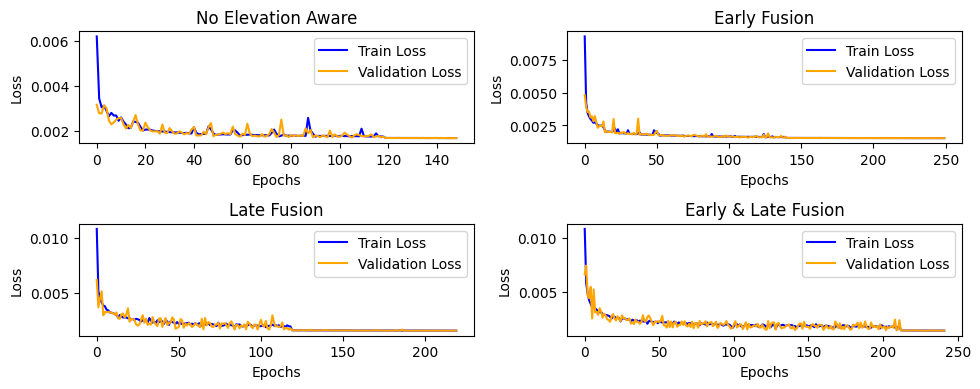

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(2, 2, 1)
plt.plot(nodem_history['loss'], label='Train Loss', color='blue')
plt.plot(nodem_history['val_loss'], label='Validation Loss', color='orange')
plt.title('No Elevation Aware')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(early_history['loss'], label='Train Loss', color='blue')
plt.plot(early_history['val_loss'], label='Validation Loss', color='orange')
plt.title('Early Fusion')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(late_history['loss'], label='Train Loss', color='blue')
plt.plot(late_history['val_loss'], label='Validation Loss', color='orange')
plt.title('Late Fusion')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(comb_history['loss'], label='Train Loss', color='blue')
plt.plot(comb_history['val_loss'], label='Validation Loss', color='orange')
plt.title('Early & Late Fusion')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# **Aspect**

In [ ]:
with open('models/history_0_5to0_25_deg_dem_4a.pkl', 'rb') as f:
  aspect_history = pickle.load(f)

In [ ]:
aspect_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_4a.keras', custom_objects={
    'psnr': psnr,
    'ssim': ssim,
    'residual_block': residual_block,
    'expand_static_aspect_0_5': expand_static_aspect_0_5,
    'expand_static_aspect_0_25': expand_static_aspect_0_25
}, safe_mode=False)


In [ ]:
avg_ms = measure_inference_time(aspect_model, testX)
print(f"Average inference time per sample: {avg_ms:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Average inference time per sample: 3.44 ms


In [ ]:
aspect_mse, aspect_mae, aspect_psnr, aspect_ssim = evaluate_per_pixel(aspect_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step


In [ ]:
degrees_mae_aspect = denormalize_mae(aspect_mae, global_Std)

# **Slope**

In [ ]:
with open('models/history_0_5to0_25_deg_dem_4b.pkl', 'rb') as f:
  slope_history = pickle.load(f)

In [ ]:
slope_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_4b.keras', custom_objects={
    'psnr': psnr,
    'ssim': ssim,
    'residual_block': residual_block,
    'expand_static_slope_0_5': expand_static_slope_0_5,
    'expand_static_slope_0_25': expand_static_slope_0_25
}, safe_mode=False)


In [ ]:
avg_ms = measure_inference_time(slope_model, testX)
print(f"Average inference time per sample: {avg_ms:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Average inference time per sample: 3.41 ms


In [ ]:
slope_mse, slope_mae, slope_psnr, slope_ssim = evaluate_per_pixel(slope_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step


In [ ]:
degrees_mae_slope = denormalize_mae(slope_mae, global_Std)

# **Elevation & Aspect**

In [ ]:
with open('models/history_0_5to0_25_deg_dem_4c.pkl', 'rb') as f:
  elevaspect_history = pickle.load(f)

In [ ]:
elevaspect_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_4c.keras', custom_objects={
    'psnr': psnr,
    'ssim': ssim,
    'residual_block': residual_block,
    'expand_static_data_dem_0_5': expand_static_data_dem_0_5,
    'expand_static_data_dem_0_25': expand_static_data_dem_0_25,
    'expand_static_aspect_0_5': expand_static_aspect_0_5,
    'expand_static_aspect_0_25': expand_static_aspect_0_25
}, safe_mode=False)

In [ ]:
avg_ms = measure_inference_time(elevaspect_model, testX)
print(f"Average inference time per sample: {avg_ms:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Average inference time per sample: 3.38 ms


In [ ]:
elevaspect_mse, elevaspect_mae, elevaspect_psnr, elevaspect_ssim = evaluate_per_pixel(elevaspect_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step


In [ ]:
degrees_mae_elevaspect = denormalize_mae(elevaspect_mae, global_Std)

# **Elevation & Slope**

In [7]:
with open('models/history_0_5to0_25_deg_dem_4d.pkl', 'rb') as f:
  elevslope_history = pickle.load(f)

In [8]:
elevslope_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_4d.keras', custom_objects={
    'psnr': psnr,
    'ssim': ssim,
    'residual_block': residual_block,
    'expand_static_data_dem_0_5': expand_static_data_dem_0_5,
    'expand_static_data_dem_0_25': expand_static_data_dem_0_25,
    'expand_static_slope_0_5': expand_static_slope_0_5,
    'expand_static_slope_0_25': expand_static_slope_0_25
}, safe_mode=False)

In [9]:
avg_ms = measure_inference_time(elevslope_model, testX)
print(f"Average inference time per sample: {avg_ms:.2f} ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
Average inference time per sample: 4.62 ms


In [10]:
elevslope_mse, elevslope_mae, elevslope_psnr, elevslope_ssim = evaluate_per_pixel(elevslope_model, testX, testY)

144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step


In [ ]:
degrees_mae_elevslope = denormalize_mae(elevslope_mae, global_Std)

## **History Plots**

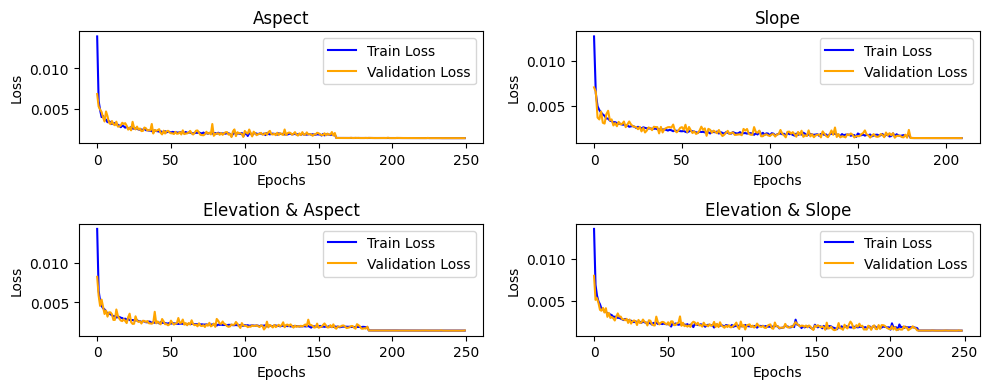

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(2, 2, 1)
plt.plot(aspect_history['loss'], label='Train Loss', color='blue')
plt.plot(aspect_history['val_loss'], label='Validation Loss', color='orange')
plt.title('Aspect')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(slope_history['loss'], label='Train Loss', color='blue')
plt.plot(slope_history['val_loss'], label='Validation Loss', color='orange')
plt.title('Slope')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(elevaspect_history['loss'], label='Train Loss', color='blue')
plt.plot(elevaspect_history['val_loss'], label='Validation Loss', color='orange')
plt.title('Elevation & Aspect')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(elevslope_history['loss'], label='Train Loss', color='blue')
plt.plot(elevslope_history['val_loss'], label='Validation Loss', color='orange')
plt.title('Elevation & Slope')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

## **Degrees MAE Plots**

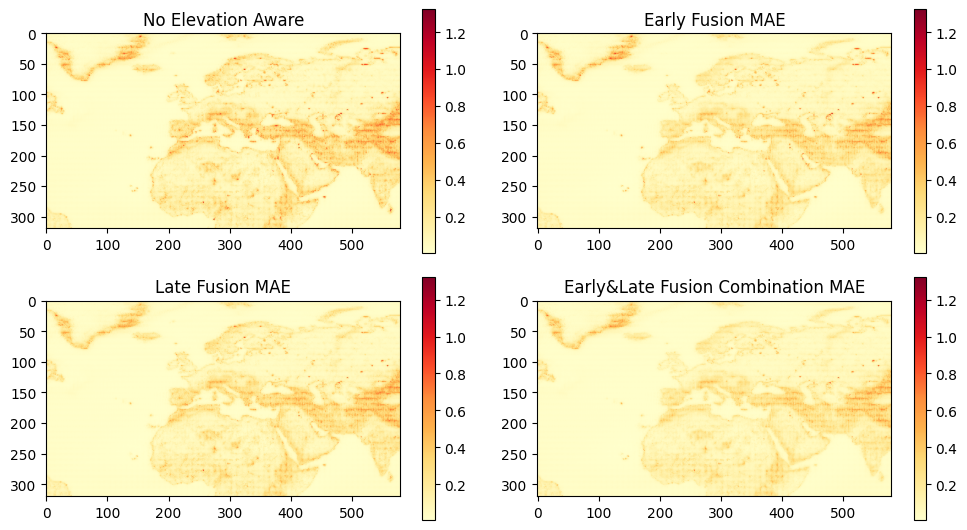

In [ ]:
# Plot the heatmaps
fig, axes = plt.subplots(2, 2, figsize=(10, 5.5))

# Determine shared color scale across all three maps
vmin = min(degrees_mae_nodem.min(), degrees_mae_early.min(), degrees_mae_late.min(), degrees_mae_comb.min())
vmax = max(degrees_mae_nodem.max(), degrees_mae_early.max(), degrees_mae_late.max(), degrees_mae_comb.max())

# 1. NoDEM
im0 = axes[0, 0].imshow(degrees_mae_nodem, cmap='YlOrRd', vmin=vmin, vmax=vmax)
axes[0, 0].set_title("No Elevation Aware")
plt.colorbar(im0, ax=axes[0, 0])

# 2. Early Fusion
im1 = axes[0, 1].imshow(degrees_mae_early, cmap='YlOrRd', vmin=vmin, vmax=vmax)
axes[0, 1].set_title("Early Fusion MAE")
plt.colorbar(im1, ax=axes[0, 1])

# 3. Late Fusion
im2 = axes[1, 0].imshow(degrees_mae_late, cmap='YlOrRd', vmin=vmin, vmax=vmax)
axes[1, 0].set_title("Late Fusion MAE")
plt.colorbar(im2, ax=axes[1, 0])

# 4. Early&Late Fusion Combination
im2 = axes[1, 1].imshow(degrees_mae_comb, cmap='YlOrRd', vmin=vmin, vmax=vmax)
axes[1, 1].set_title("Early&Late Fusion Combination MAE")
plt.colorbar(im2, ax=axes[1, 1])

# Final layout tweaks
plt.tight_layout()
plt.show()

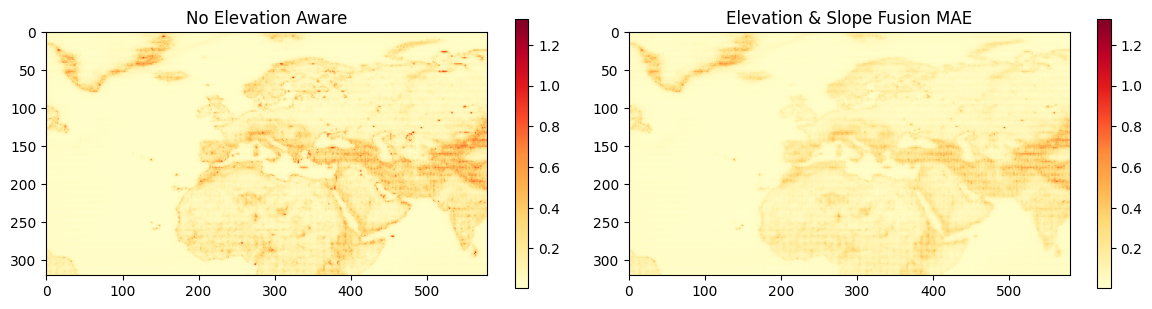

In [ ]:
# Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Determine shared color scale across all three maps
vmin = min(degrees_mae_nodem.min(), degrees_mae_comb.min())
vmax = max(degrees_mae_nodem.max(), degrees_mae_comb.max())

# 1. NoDEM
im0 = axes[0].imshow(degrees_mae_nodem, cmap='YlOrRd', vmin=vmin, vmax=vmax)
axes[0].set_title("No Elevation Aware")
plt.colorbar(im0, ax=axes[0])

# 2. Early Fusion
im1 = axes[1].imshow(degrees_mae_elevslope, cmap='YlOrRd', vmin=vmin, vmax=vmax)
axes[1].set_title("Elevation & Slope Fusion MAE")
plt.colorbar(im1, ax=axes[1])


# Final layout tweaks
plt.tight_layout()
plt.show()

In [ ]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = feat_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


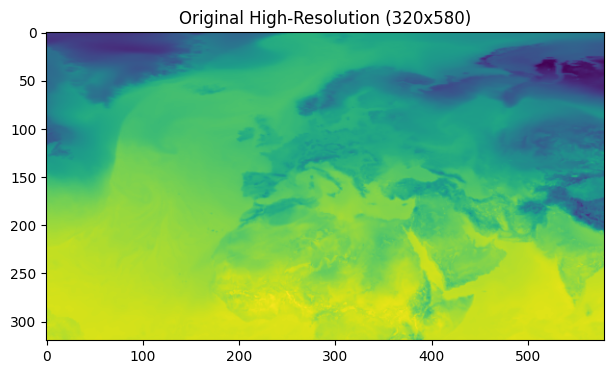

In [ ]:
high_res = np.squeeze(high_res_data)
plt.figure(figsize=(8, 4))
plt.subplot(1, 1, 1)
plt.title(f"Original High-Resolution ({high_res.shape[0]}x{high_res.shape[1]})")
plt.imshow(high_res, cmap='viridis')

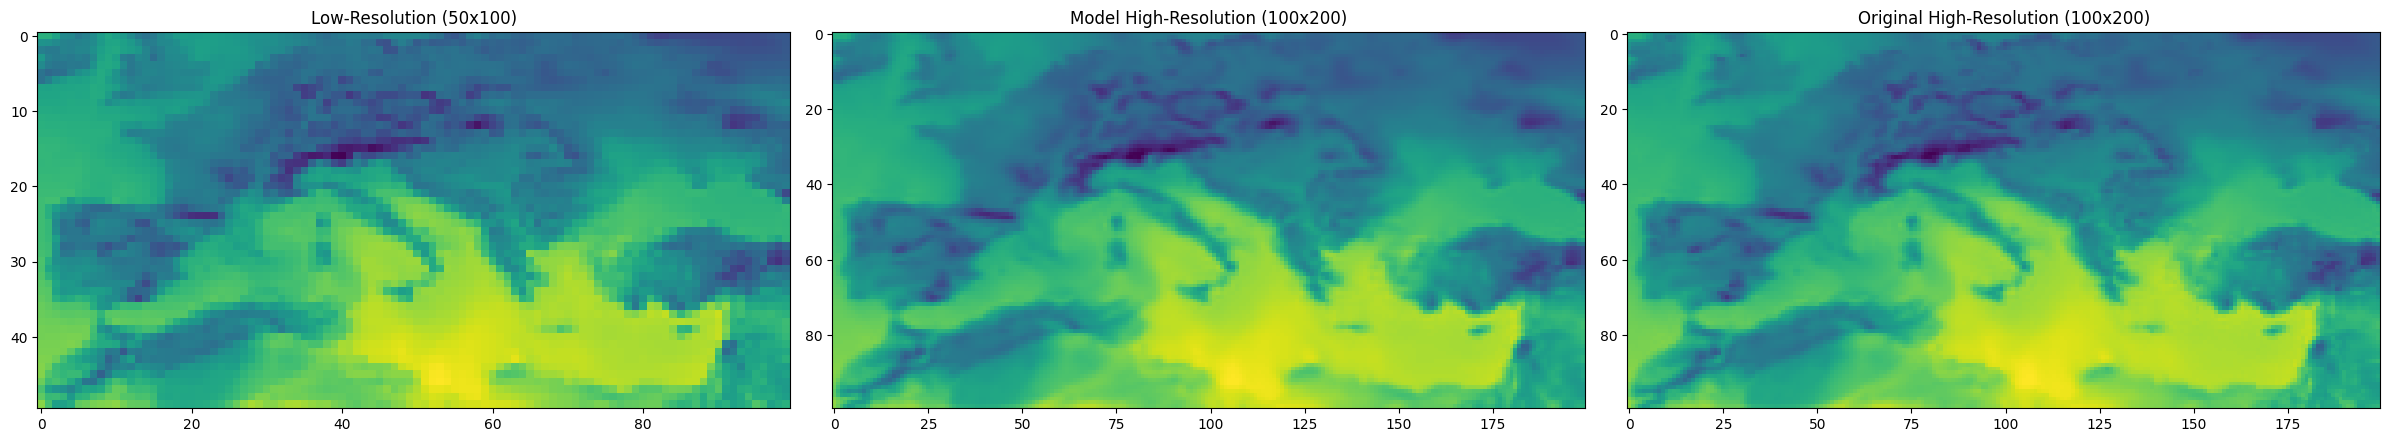

In [ ]:
plt.figure(figsize=(24, 6))

low_res = low_res_input[50:100, 100:200]
high_res = np.squeeze(high_res_data)[100:200, 200:400]
model_output = np.squeeze(high_res_output)[100:200, 200:400]

# Low-Resolution Image
plt.subplot(1, 3, 1)
plt.title(f"Low-Resolution ({low_res.shape[0]}x{low_res.shape[1]})")
plt.imshow(low_res, cmap='viridis')
# plt.colorbar()

# Model High-Resolution Image
plt.subplot(1, 3, 2)
plt.title(f"Model High-Resolution ({model_output.shape[0]}x{model_output.shape[1]})")
plt.imshow(model_output, cmap='viridis')
# plt.colorbar()

# Original High-Resolution Image
plt.subplot(1, 3, 3)
plt.title(f"Original High-Resolution ({high_res.shape[0]}x{high_res.shape[1]})")
plt.imshow(high_res, cmap='viridis') #cmap='viridis', vmin=0, vmax=1
# plt.colorbar()

plt.tight_layout()  # Ensures the subplots don't overlap
plt.show()

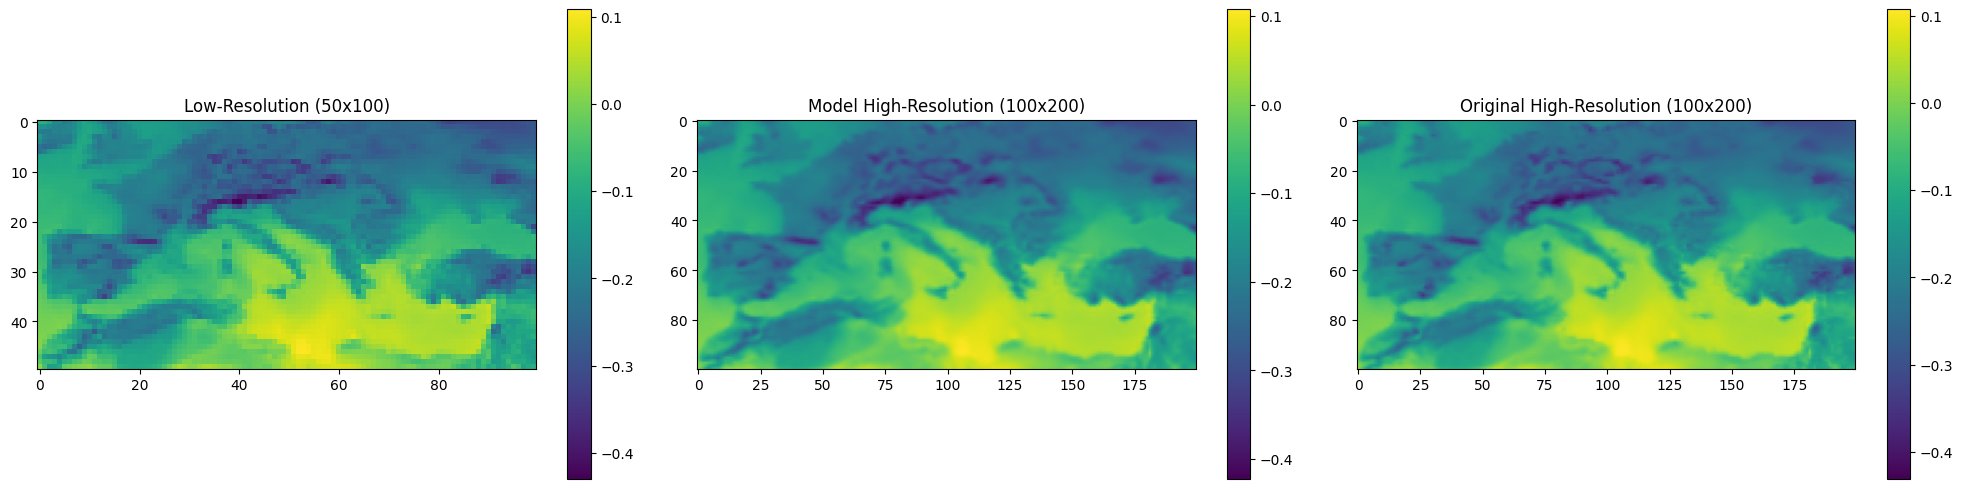

In [ ]:
### Europe
plot_to_compare(low_res_input[50:100, 100:200], np.squeeze(high_res_data)[100:200, 200:400],  np.squeeze(high_res_output)[100:200, 200:400], 'viridis')